In [1]:
from importlib import import_module

In [2]:
import os
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from ase.atoms import Atoms
from ase.build import bulk
from ase.io import write
from adis_tools.parsers import parse_pw

In [3]:
from inspect import isfunction

In [4]:
from jobflow import job, Flow
from jobflow.managers.local import run_locally

In [5]:
def get_kwargs(lst):
    return {t['targetHandle']: {'source': t['source'], 'sourceHandle': t['sourceHandle']} for t in lst}

In [6]:
def resort_total_lst(total_dict, nodes_dict):
    nodes_with_dep_lst = list(sorted(total_dict.keys()))
    nodes_without_dep_lst = [k for k in nodes_dict.keys() if k not in nodes_with_dep_lst]
    ordered_lst = []
    total_new_dict = {}
    while len(total_new_dict) < len(total_dict):
        for ind in sorted(total_dict.keys()):
            connect = total_dict[ind]
            if ind not in ordered_lst:
                source_lst = [sd["source"] for sd in connect.values()]
                if all([s in ordered_lst or s in nodes_without_dep_lst for s in source_lst]):
                    ordered_lst.append(ind)
                    total_new_dict[ind] = connect
    return total_new_dict

In [7]:
def group_edges(edges_lst):
    # edges_sorted_lst = sorted(edges_lst, key=lambda x: x['target'], reverse=True)     
    total_dict = {}
    for ed_major in edges_lst:
        target_id = ed_major["target"]
        tmp_lst = []
        if target_id not in total_dict.keys():
            for ed in edges_lst:
                if target_id == ed["target"]:
                    tmp_lst.append(ed)
            total_dict[target_id] = get_kwargs(lst=tmp_lst)
    # total_dict[target_id] = get_kwargs(lst=tmp_lst)
    return total_dict

In [8]:
def get_input_dict(nodes_dict):
    return {k:v for k, v in nodes_dict.items() if not isfunction(v)}

In [9]:
def get_workflow(nodes_dict, input_dict, total_dict, source_handles_dict):
    def get_attr_helper(obj, source_handle):
        # print("attr_helper", source_handle, getattr(obj, "output"), getattr(getattr(obj, "output"), source_handle))
        if source_handle is None:
            return getattr(obj, "output") 
        else:
            return getattr(getattr(obj, "output"), source_handle)
    
    memory_dict = {}
    for k in total_dict.keys():
        v = nodes_dict[k]
        if isfunction(v):
            if k in source_handles_dict.keys():
                # print(k, {el: el for el in source_handles_dict[k] if el is not None})
                fn = job(method=v, data=[el for el in source_handles_dict[k] if el is not None])
            else:
                fn = job(method=v)
            kwargs = {
                kw: input_dict[vw['source']] if vw['source'] in input_dict else get_attr_helper(obj=memory_dict[vw['source']], source_handle=vw['sourceHandle']) 
                for kw, vw in total_dict[k].items()
            }
            print(k, kwargs)
            memory_dict[k] = fn(**kwargs)
    return list(memory_dict.values())

In [10]:
def get_source_handles(edges_lst):
    source_handle_dict = {}
    for ed in edges_lst: 
        if ed['source'] not in source_handle_dict.keys():
            source_handle_dict[ed['source']] = [ed['sourceHandle']]
        else:
            source_handle_dict[ed['source']].append(ed['sourceHandle'])
    return source_handle_dict

In [11]:
def get_item_from_tuple(input_obj, index, index_lst):
    if isinstance(input_obj, dict):  
        return input_obj[index]
    else:  # input_obj is a tuple
        return list(input_obj)[index_lst.index(index)]

In [12]:
def get_source_handles(edges_lst):
    source_handle_dict = {}
    for ed in edges_lst: 
        if ed['source'] not in source_handle_dict.keys():
            source_handle_dict[ed['source']] = [ed['sourceHandle']]
        else:
            source_handle_dict[ed['source']].append(ed['sourceHandle'])
    return {
        k: list(range(len(v))) if len(v) > 1 and all([el is None for el in v]) else v 
        for k, v in source_handle_dict.items()
    }

In [13]:
def get_dict(**kwargs):
    return {k: v for k, v in kwargs.items()}

In [14]:
def get_list(**kwargs):
    return list(kwargs.values())

In [15]:
def write_input(input_dict, working_directory="."):
    filename = os.path.join(working_directory, "input.pwi")
    os.makedirs(working_directory, exist_ok=True)
    write(
        filename=filename,
        images=Atoms(**input_dict["structure"]),
        Crystal=True,
        kpts=input_dict["kpts"],
        input_data={
            "calculation": input_dict["calculation"],
            "occupations": "smearing",
            "degauss": input_dict["smearing"],
        },
        pseudopotentials=input_dict["pseudopotentials"],
        tstress=True,
        tprnfor=True,
    )

In [16]:
def collect_output(working_directory="."):
    output = parse_pw(os.path.join(working_directory, "pwscf.xml"))
    return {
        "structure": output["ase_structure"].todict(),
        "energy": output["energy"],
        "volume": output["ase_structure"].get_volume(),
    }

In [17]:
# @job(output_key_lst=["energy", "volume", "structure"])
def calculate_qe(working_directory, input_dict):
    write_input(
        input_dict=input_dict,
        working_directory=working_directory,
    )
    subprocess.check_output(
        "mpirun -np 1 pw.x -in input.pwi > output.pwo",
        cwd=working_directory,
        shell=True,
    )
    return collect_output(working_directory=working_directory)

In [18]:
# @job
def generate_structures(structure, strain_lst):
    structure_lst = []
    for strain in strain_lst:
        structure_strain = Atoms(**structure)
        structure_strain.set_cell(
            structure_strain.cell * strain ** (1 / 3), scale_atoms=True
        )
        structure_lst.append(structure_strain)
    return {str(i): s.todict() for i, s in enumerate(structure_lst)}

In [19]:
# @job
def plot_energy_volume_curve(volume_lst, energy_lst):
    plt.plot(volume_lst, energy_lst)
    plt.xlabel("Volume")
    plt.ylabel("Energy")
    plt.savefig("evcurve.png")

In [20]:
# @job
def plot_energy_volume_curve(volume_lst, energy_lst):
    plt.plot(volume_lst, energy_lst)
    plt.xlabel("Volume")
    plt.ylabel("Energy")
    plt.savefig("evcurve.png")

In [21]:
# @job
def get_bulk_structure(name, a, cubic):
    return bulk(
        name=name,
        a=a,
        cubic=cubic,
    ).todict()

In [22]:
pseudopotentials = {"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"}

In [23]:
nodes_dict = {  # from jobflow
    0: get_bulk_structure,
    1: calculate_qe,
    2: generate_structures,
    3: calculate_qe,
    4: calculate_qe,
    5: calculate_qe,
    6: calculate_qe,
    7: calculate_qe,
    8: plot_energy_volume_curve,
    9: 'Al',
    10: 4.05,
    11: True,
    12: 'mini',
    13: get_dict,
    14: {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'},
    15: [3, 3, 3],
    16: 'vc-relax',
    17: 0.02,
    18: [0.9, 0.9500000000000001, 1.0, 1.05, 1.1],
    19: 'strain_0',
    20: get_dict,
    21: 'scf',
    22: 'strain_1',
    23: get_dict,
    24: 'strain_2',
    25: get_dict,
    26: 'strain_3',
    27: get_dict,
    28: 'strain_4',
    29: get_dict,
    30: get_list,
    31: get_list,
}

In [24]:
edges_lst = [
    {'target': 0, 'targetHandle': 'name', 'source': 9, 'sourceHandle': None},
    {'target': 0, 'targetHandle': 'a', 'source': 10, 'sourceHandle': None},
    {'target': 0, 'targetHandle': 'cubic', 'source': 11, 'sourceHandle': None},
    {'target': 1, 'targetHandle': 'working_directory', 'source': 12, 'sourceHandle': None},
    {'target': 13, 'targetHandle': 'structure', 'source': 0, 'sourceHandle': None},
    {'target': 13, 'targetHandle': 'pseudopotentials', 'source': 14, 'sourceHandle': None},
    {'target': 13, 'targetHandle': 'kpts', 'source': 15, 'sourceHandle': None},
    {'target': 13, 'targetHandle': 'calculation', 'source': 16, 'sourceHandle': None},
    {'target': 13, 'targetHandle': 'smearing', 'source': 17, 'sourceHandle': None},
    {'target': 1, 'targetHandle': 'input_dict', 'source': 13, 'sourceHandle': None},
    {'target': 2, 'targetHandle': 'structure', 'source': 1, 'sourceHandle': 'structure'},
    {'target': 2, 'targetHandle': 'strain_lst', 'source': 18, 'sourceHandle': None},
    {'target': 3, 'targetHandle': 'working_directory', 'source': 19, 'sourceHandle': None},
    {'target': 20, 'targetHandle': 'structure', 'source': 2, 'sourceHandle': '0'},
    {'target': 20, 'targetHandle': 'pseudopotentials', 'source': 14, 'sourceHandle': None},
    {'target': 20, 'targetHandle': 'kpts', 'source': 15, 'sourceHandle': None},
    {'target': 20, 'targetHandle': 'calculation', 'source': 21, 'sourceHandle': None},
    {'target': 20, 'targetHandle': 'smearing', 'source': 17, 'sourceHandle': None},
    {'target': 3, 'targetHandle': 'input_dict', 'source': 20, 'sourceHandle': None},
    {'target': 4, 'targetHandle': 'working_directory', 'source': 22, 'sourceHandle': None},
    {'target': 23, 'targetHandle': 'structure', 'source': 2, 'sourceHandle': '1'},
    {'target': 23, 'targetHandle': 'pseudopotentials', 'source': 14, 'sourceHandle': None},
    {'target': 23, 'targetHandle': 'kpts', 'source': 15, 'sourceHandle': None},
    {'target': 23, 'targetHandle': 'calculation', 'source': 21, 'sourceHandle': None},
    {'target': 23, 'targetHandle': 'smearing', 'source': 17, 'sourceHandle': None},
    {'target': 4, 'targetHandle': 'input_dict', 'source': 23, 'sourceHandle': None},
    {'target': 5, 'targetHandle': 'working_directory', 'source': 24, 'sourceHandle': None},
    {'target': 25, 'targetHandle': 'structure', 'source': 2, 'sourceHandle': '2'},
    {'target': 25, 'targetHandle': 'pseudopotentials', 'source': 14, 'sourceHandle': None},
    {'target': 25, 'targetHandle': 'kpts', 'source': 15, 'sourceHandle': None},
    {'target': 25, 'targetHandle': 'calculation', 'source': 21, 'sourceHandle': None},
    {'target': 25, 'targetHandle': 'smearing', 'source': 17, 'sourceHandle': None},
    {'target': 5, 'targetHandle': 'input_dict', 'source': 25, 'sourceHandle': None},
    {'target': 6, 'targetHandle': 'working_directory', 'source': 26, 'sourceHandle': None},
    {'target': 27, 'targetHandle': 'structure', 'source': 2, 'sourceHandle': '3'},
    {'target': 27, 'targetHandle': 'pseudopotentials', 'source': 14, 'sourceHandle': None},
    {'target': 27, 'targetHandle': 'kpts', 'source': 15, 'sourceHandle': None},
    {'target': 27, 'targetHandle': 'calculation', 'source': 21, 'sourceHandle': None},
    {'target': 27, 'targetHandle': 'smearing', 'source': 17, 'sourceHandle': None},
    {'target': 6, 'targetHandle': 'input_dict', 'source': 27, 'sourceHandle': None},
    {'target': 7, 'targetHandle': 'working_directory', 'source': 28, 'sourceHandle': None},
    {'target': 29, 'targetHandle': 'structure', 'source': 2, 'sourceHandle': '4'},
    {'target': 29, 'targetHandle': 'pseudopotentials', 'source': 14, 'sourceHandle': None},
    {'target': 29, 'targetHandle': 'kpts', 'source': 15, 'sourceHandle': None},
    {'target': 29, 'targetHandle': 'calculation', 'source': 21, 'sourceHandle': None},
    {'target': 29, 'targetHandle': 'smearing', 'source': 17, 'sourceHandle': None},
    {'target': 7, 'targetHandle': 'input_dict', 'source': 29, 'sourceHandle': None},
    {'target': 30, 'targetHandle': "0", 'source': 3, 'sourceHandle': 'volume'},
    {'target': 30, 'targetHandle': "1", 'source': 4, 'sourceHandle': 'volume'},
    {'target': 30, 'targetHandle': "2", 'source': 5, 'sourceHandle': 'volume'},
    {'target': 30, 'targetHandle': "3", 'source': 6, 'sourceHandle': 'volume'},
    {'target': 30, 'targetHandle': "4", 'source': 7, 'sourceHandle': 'volume'},
    {'target': 8, 'targetHandle': 'volume_lst', 'source': 30, 'sourceHandle': None},
    {'target': 31, 'targetHandle': "0", 'source': 3, 'sourceHandle': 'energy'},
    {'target': 31, 'targetHandle': "1", 'source': 4, 'sourceHandle': 'energy'},
    {'target': 31, 'targetHandle': "2", 'source': 5, 'sourceHandle': 'energy'},
    {'target': 31, 'targetHandle': "3", 'source': 6, 'sourceHandle': 'energy'},
    {'target': 31, 'targetHandle': "4", 'source': 7, 'sourceHandle': 'energy'},
    {'target': 8, 'targetHandle': 'energy_lst', 'source': 31, 'sourceHandle': None},
]

In [25]:
def fine_root_node(nodes_dict, edges_lst):
    source_count_dict = {k: sum([ed["source"] == k for ed in edges_lst]) for k in nodes_dict.keys()}
    return min(source_count_dict, key=source_count_dict.get)
            

In [26]:
root_node = fine_root_node(nodes_dict=nodes_dict, edges_lst=edges_lst)
root_node

8

In [27]:
source_handles_dict = get_source_handles(edges_lst=edges_lst)
source_handles_dict

{9: [None],
 10: [None],
 11: [None],
 12: [None],
 0: [None],
 14: [0, 1, 2, 3, 4, 5],
 15: [0, 1, 2, 3, 4, 5],
 16: [None],
 17: [0, 1, 2, 3, 4, 5],
 13: [None],
 1: ['structure'],
 18: [None],
 19: [None],
 2: ['0', '1', '2', '3', '4'],
 21: [0, 1, 2, 3, 4],
 20: [None],
 22: [None],
 23: [None],
 24: [None],
 25: [None],
 26: [None],
 27: [None],
 28: [None],
 29: [None],
 3: ['volume', 'energy'],
 4: ['volume', 'energy'],
 5: ['volume', 'energy'],
 6: ['volume', 'energy'],
 7: ['volume', 'energy'],
 30: [None],
 31: [None]}

In [28]:
total_dict = group_edges(edges_lst=edges_lst)
input_dict = get_input_dict(nodes_dict=nodes_dict)

In [29]:
total_dict, input_dict

({0: {'name': {'source': 9, 'sourceHandle': None},
   'a': {'source': 10, 'sourceHandle': None},
   'cubic': {'source': 11, 'sourceHandle': None}},
  1: {'working_directory': {'source': 12, 'sourceHandle': None},
   'input_dict': {'source': 13, 'sourceHandle': None}},
  13: {'structure': {'source': 0, 'sourceHandle': None},
   'pseudopotentials': {'source': 14, 'sourceHandle': None},
   'kpts': {'source': 15, 'sourceHandle': None},
   'calculation': {'source': 16, 'sourceHandle': None},
   'smearing': {'source': 17, 'sourceHandle': None}},
  2: {'structure': {'source': 1, 'sourceHandle': 'structure'},
   'strain_lst': {'source': 18, 'sourceHandle': None}},
  3: {'working_directory': {'source': 19, 'sourceHandle': None},
   'input_dict': {'source': 20, 'sourceHandle': None}},
  20: {'structure': {'source': 2, 'sourceHandle': '0'},
   'pseudopotentials': {'source': 14, 'sourceHandle': None},
   'kpts': {'source': 15, 'sourceHandle': None},
   'calculation': {'source': 21, 'sourceHandle':

In [30]:
new_total_dict = resort_total_lst(total_dict=total_dict, nodes_dict=nodes_dict)
new_total_dict

{0: {'name': {'source': 9, 'sourceHandle': None},
  'a': {'source': 10, 'sourceHandle': None},
  'cubic': {'source': 11, 'sourceHandle': None}},
 13: {'structure': {'source': 0, 'sourceHandle': None},
  'pseudopotentials': {'source': 14, 'sourceHandle': None},
  'kpts': {'source': 15, 'sourceHandle': None},
  'calculation': {'source': 16, 'sourceHandle': None},
  'smearing': {'source': 17, 'sourceHandle': None}},
 1: {'working_directory': {'source': 12, 'sourceHandle': None},
  'input_dict': {'source': 13, 'sourceHandle': None}},
 2: {'structure': {'source': 1, 'sourceHandle': 'structure'},
  'strain_lst': {'source': 18, 'sourceHandle': None}},
 20: {'structure': {'source': 2, 'sourceHandle': '0'},
  'pseudopotentials': {'source': 14, 'sourceHandle': None},
  'kpts': {'source': 15, 'sourceHandle': None},
  'calculation': {'source': 21, 'sourceHandle': None},
  'smearing': {'source': 17, 'sourceHandle': None}},
 23: {'structure': {'source': 2, 'sourceHandle': '1'},
  'pseudopotentials':

In [31]:
task_lst = get_workflow(
    nodes_dict=nodes_dict, 
    input_dict=input_dict, 
    total_dict=new_total_dict,
    source_handles_dict=source_handles_dict,
)

0 {'name': 'Al', 'a': 4.05, 'cubic': True}
13 {'structure': OutputReference(b4a48a0d-8db2-4a7a-82cf-8bb62cef4fcc), 'pseudopotentials': {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}, 'kpts': [3, 3, 3], 'calculation': 'vc-relax', 'smearing': 0.02}
1 {'working_directory': 'mini', 'input_dict': OutputReference(c3c5fdbf-9d83-4517-be76-3c253fd19a68)}
2 {'structure': OutputReference(08c347f2-4374-4148-ad63-cbc63123c9b5, .structure), 'strain_lst': [0.9, 0.9500000000000001, 1.0, 1.05, 1.1]}
20 {'structure': OutputReference(045577d2-e868-4a0a-b67c-f02215ed437a, .0), 'pseudopotentials': {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}, 'kpts': [3, 3, 3], 'calculation': 'scf', 'smearing': 0.02}
23 {'structure': OutputReference(045577d2-e868-4a0a-b67c-f02215ed437a, .1), 'pseudopotentials': {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}, 'kpts': [3, 3, 3], 'calculation': 'scf', 'smearing': 0.02}
25 {'structure': OutputReference(045577d2-e868-4a0a-b67c-f02215ed437a, .2), 'pseudopotentials': {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.U

In [32]:
flow = Flow(task_lst)

2025-01-17 14:52:13,854 INFO Started executing jobs locally
2025-01-17 14:52:14,594 INFO Starting job - get_bulk_structure (b4a48a0d-8db2-4a7a-82cf-8bb62cef4fcc)
2025-01-17 14:52:14,599 INFO Finished job - get_bulk_structure (b4a48a0d-8db2-4a7a-82cf-8bb62cef4fcc)
2025-01-17 14:52:14,600 INFO Starting job - get_dict (c3c5fdbf-9d83-4517-be76-3c253fd19a68)
2025-01-17 14:52:14,602 INFO Finished job - get_dict (c3c5fdbf-9d83-4517-be76-3c253fd19a68)
2025-01-17 14:52:14,602 INFO Starting job - calculate_qe (08c347f2-4374-4148-ad63-cbc63123c9b5)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-01-17 14:52:27,833 INFO Finished job - calculate_qe (08c347f2-4374-4148-ad63-cbc63123c9b5)
2025-01-17 14:52:27,833 INFO Starting job - generate_structures (045577d2-e868-4a0a-b67c-f02215ed437a)
2025-01-17 14:52:27,836 INFO Finished job - generate_structures (045577d2-e868-4a0a-b67c-f02215ed437a)
2025-01-17 14:52:27,837 INFO Starting job - get_dict (70d45a01-973a-42c6-abee-190a85036b67)
2025-01-17 14:52:27,839 INFO Finished job - get_dict (70d45a01-973a-42c6-abee-190a85036b67)
2025-01-17 14:52:27,839 INFO Starting job - get_dict (da71d272-80bc-4399-a460-2d45caa0aa4a)
2025-01-17 14:52:27,841 INFO Finished job - get_dict (da71d272-80bc-4399-a460-2d45caa0aa4a)
2025-01-17 14:52:27,841 INFO Starting job - get_dict (90c318bf-ce10-4834-a0d2-254224d8cb7f)
2025-01-17 14:52:27,843 INFO Finished job - get_dict (90c318bf-ce10-4834-a0d2-254224d8cb7f)
2025-01-17 14:52:27,843 INFO Starting job - get_dict (d47f5ce9-144b-4d01-87e6-ae9aa1cec060)
2025-01-17 14:52:27,845 INFO Finished job - get_dict (

Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-01-17 14:52:34,081 INFO Finished job - calculate_qe (d90cda2e-bdef-4718-a98c-c1c8250bd091)
2025-01-17 14:52:34,081 INFO Starting job - calculate_qe (8a427e06-f9ae-4f30-915f-f590181d9591)
2025-01-17 14:52:37,498 INFO Finished job - calculate_qe (8a427e06-f9ae-4f30-915f-f590181d9591)
2025-01-17 14:52:37,498 INFO Starting job - calculate_qe (a25c7ca7-7413-4495-b16a-f8ca261bb816)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-01-17 14:52:41,281 INFO Finished job - calculate_qe (a25c7ca7-7413-4495-b16a-f8ca261bb816)
2025-01-17 14:52:41,282 INFO Starting job - calculate_qe (1fb42a89-1daf-4968-856f-9421a7bc1326)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-01-17 14:52:45,163 INFO Finished job - calculate_qe (1fb42a89-1daf-4968-856f-9421a7bc1326)
2025-01-17 14:52:45,164 INFO Starting job - get_list (9a938237-68a0-4ea2-a355-b558a1030073)
2025-01-17 14:52:45,166 INFO Finished job - get_list (9a938237-68a0-4ea2-a355-b558a1030073)
2025-01-17 14:52:45,167 INFO Starting job - get_list (42764edc-5596-4a37-aaea-8c9d595d769e)
2025-01-17 14:52:45,169 INFO Finished job - get_list (42764edc-5596-4a37-aaea-8c9d595d769e)
2025-01-17 14:52:45,169 INFO Starting job - plot_energy_volume_curve (fa13a862-7064-4b11-8f0b-99a308c2f79a)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-01-17 14:52:45,288 INFO Finished job - plot_energy_volume_curve (fa13a862-7064-4b11-8f0b-99a308c2f79a)
2025-01-17 14:52:45,289 INFO Finished executing jobs locally


{'b4a48a0d-8db2-4a7a-82cf-8bb62cef4fcc': {1: Response(output={'numbers': array([13, 13, 13, 13]), 'positions': array([[0.   , 0.   , 0.   ],
         [0.   , 2.025, 2.025],
         [2.025, 0.   , 2.025],
         [2.025, 2.025, 0.   ]]), 'cell': array([[4.05, 0.  , 0.  ],
         [0.  , 4.05, 0.  ],
         [0.  , 0.  , 4.05]]), 'pbc': array([ True,  True,  True])}, detour=None, addition=None, replace=None, stored_data=None, stop_children=False, stop_jobflow=False, job_dir=PosixPath('/home/janssen/notebooks/2025/2025-01-16-jobflow-qe'))},
 'c3c5fdbf-9d83-4517-be76-3c253fd19a68': {1: Response(output={'structure': {'numbers': [13, 13, 13, 13], 'positions': [[0.0, 0.0, 0.0], [0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]], 'cell': [[4.05, 0.0, 0.0], [0.0, 4.05, 0.0], [0.0, 0.0, 4.05]], 'pbc': [True, True, True]}, 'pseudopotentials': {'Al': 'Al.pbe-n-kjpaw_psl.1.0.0.UPF'}, 'kpts': [3, 3, 3], 'calculation': 'vc-relax', 'smearing': 0.02}, detour=None, addition=None, replace

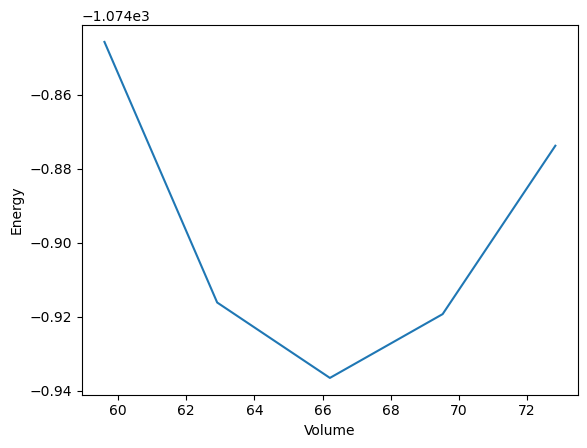

In [33]:
result = run_locally(flow)
result